# NDVI

Create an NDVI image and histogram using a PlanetScope 4-band image (PSScene4Band)

A Planet API key is required

In [10]:
import sys
sys.path.append('../')

# FIXME: Remove this block after module code has been completed
%load_ext autoreload
%autoreload 1
%aimport rstools.main

from rstools.main import midpoint_normalize, show_ndvi_fig, show_ndvi_hist, get_reflectance_coeffs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Specify input data and output folders

In [2]:
DATA_LOC = '../data/'
OUTPUT_LOC = '../output/'

## Band Order for PlanetScope 4-band images (PSScene4Band)

In [7]:
BLUE = 1
GREEN = 2
RED = 3
NIR = 4

## Specify Planet item id for PSScene4Band image

In [4]:
#PLANET_ITEM_ID = '20160831_180302_0e26' #reflectance coeffs 2.55957020415e-05 3.87396124832e-05
                                        #range NDVI (-0.999551583679821, 0.9998732042084099)

#PLANET_ITEM_ID = '20210217_173811_1026'#reflectance coeffs (3.09419250778e-05, 4.68637435774e-05)
                                        #range NDVI (-0.6696521855564906, 0.5279276908614214)

# SANTA FE OPEN SPACE 2020-07-04
#PLANET_ITEM_ID = '20200704_173510_95_1062'#reflectance coeffs (2.36459796684e-05, 3.68854257857e-05)
                                        #range NDVI (-0.11468907042978817, 0.6800783024111237)
    
# TEST DATA FROM ORIGINAL NOTEBOOK
PLANET_ITEM_ID = '20210217_173809_1026' #reflectance coeffs 3.10115984374e-05 4.696926883e-05
                                        #range NDVI (-0.6923316699660859, 0.6292593054291127)

    

## Download image and metadata from Planet

In [5]:
!planet data download --item-type PSScene4Band --dest $DATA_LOC --asset-type analytic,analytic_xml --string-in id $PLANET_ITEM_ID

activating: 0            complete: 0              elapsed: 0                    
paging: False            pending: 0                                             

activating: 1            complete: 0              downloaded: 0.00MB            
downloading: 0           elapsed: 1               paging: False                 
pending: 0                                                                      

activating: 0            complete: 0              downloaded: 0.00MB            
downloading: 1           elapsed: 2               paging: False                 
pending: 1                                                                      

activating: 0            complete: 0              downloaded: 0.00MB            
downloading: 2           elapsed: 3               paging: False                 
pending: 0                                                                      

{"item": "20210217_173809_1026", "asset": "analytic", "location": "/home/jovyan/work/data/20210217_173809

## Specify input and output files

In [23]:
# Input
filename_img = DATA_LOC + PLANET_ITEM_ID + '_3B_AnalyticMS.tif'
filename_metadata = DATA_LOC + PLANET_ITEM_ID + '_3B_AnalyticMS_metadata.xml'

# Output
filename_ndvi = OUTPUT_LOC + PLANET_ITEM_ID + '_ndvi.tif'
filename_ndvi_fig = OUTPUT_LOC + PLANET_ITEM_ID + '_ndvi-fig.png'
filename_ndvi_hist = OUTPUT_LOC + PLANET_ITEM_ID + '_ndvi-histogram.png'

## Read the Red and NIR bands

In [14]:
import rasterio
import numpy as np

# Load red and NIR bands
with rasterio.open(filename_img) as src:
    band_red = src.read(RED)
    band_nir = src.read(NIR)

## Read Reflectance Coefficients from Metadata

In [15]:
coeffs = get_reflectance_coeffs(filename_metadata)
        
coeffs[RED], coeffs[NIR]

(3.10115984374e-05, 4.696926883e-05)

## Multiply the values in each band by the TOA Reflectance Coefficients

In [16]:
band_red = band_red * coeffs[RED]
band_nir = band_nir * coeffs[NIR]

## Calculate NDVI

In [17]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI. This is the equation at the top of this guide expressed in code
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

## Review the min and max NDVI values

In [18]:
np.nanmin(ndvi), np.nanmax(ndvi)

(-0.5681955003107148, 0.7387650376327961)

## Save a single band NDVI file

In [24]:
# Read metadata from original image
kwargs = src.meta

# Update metadata for NDVI: a single band of float32 values
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Write to NDVI file
with rasterio.open(filename_ndvi, 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

## NDVI with Color Map and Color Bar 
Set midpoint according to how NDVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/

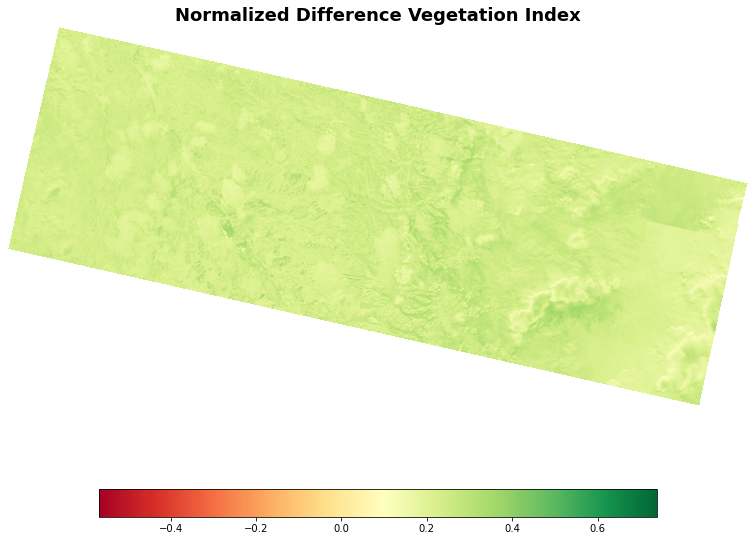

In [25]:
show_ndvi_fig(ndvi, filename_ndvi_fig, midpoint=0.1, figsize=(20, 10))

## NDVI Histogram

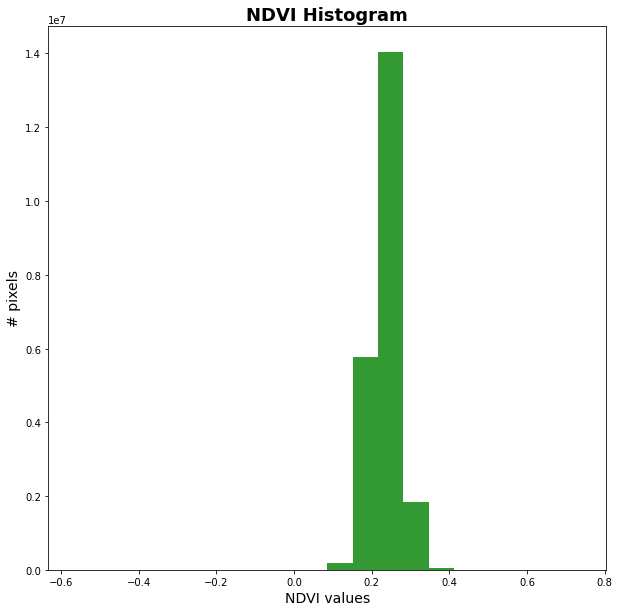

In [26]:
show_ndvi_hist(ndvi, filename_ndvi_hist, figsize=(10, 10))